In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

In [3]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
    
    

--2019-06-27 01:07:49--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.33.231.77, 13.33.231.52, 13.33.231.59, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.33.231.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  31.7MB/s    in 0.2s    

2019-06-27 01:07:50 (31.7 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'

scanpy==1.4.1 anndata==0.6.21 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1 


In [5]:
sc.settings.set_figure_params(dpi=80)

In [6]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading)

... writing an h5ad cache file to speedup reading next time


In [7]:
adata.var_names_make_unique() # this is unnecessary if using 'gene_ids'

In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

## adata have 3 main attributes:
1. adata.obs: observation means the single cells. .obs stores infor for cells. a dataframe
2. adata.var: variants mean the genes. .var stores infor for genes. a dataframe
3. adata.data or adata.X: the actual count data: each cell is a array with gene expression. This is an array of arrays.

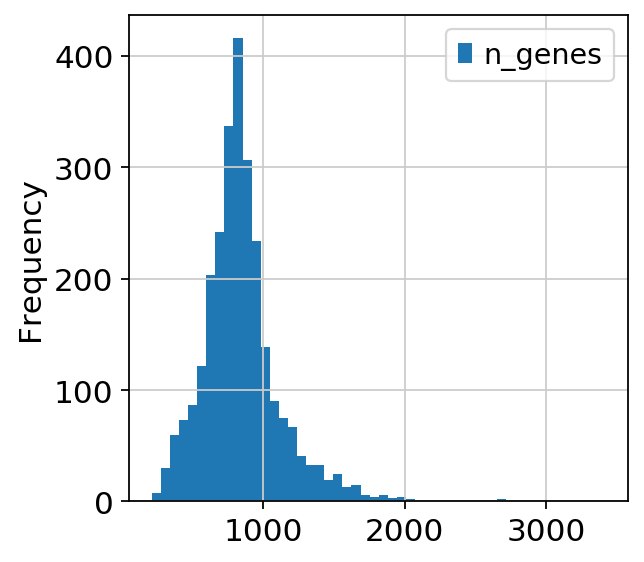

In [18]:
adata.obs.plot(kind = 'hist', bins = 50)

In [25]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

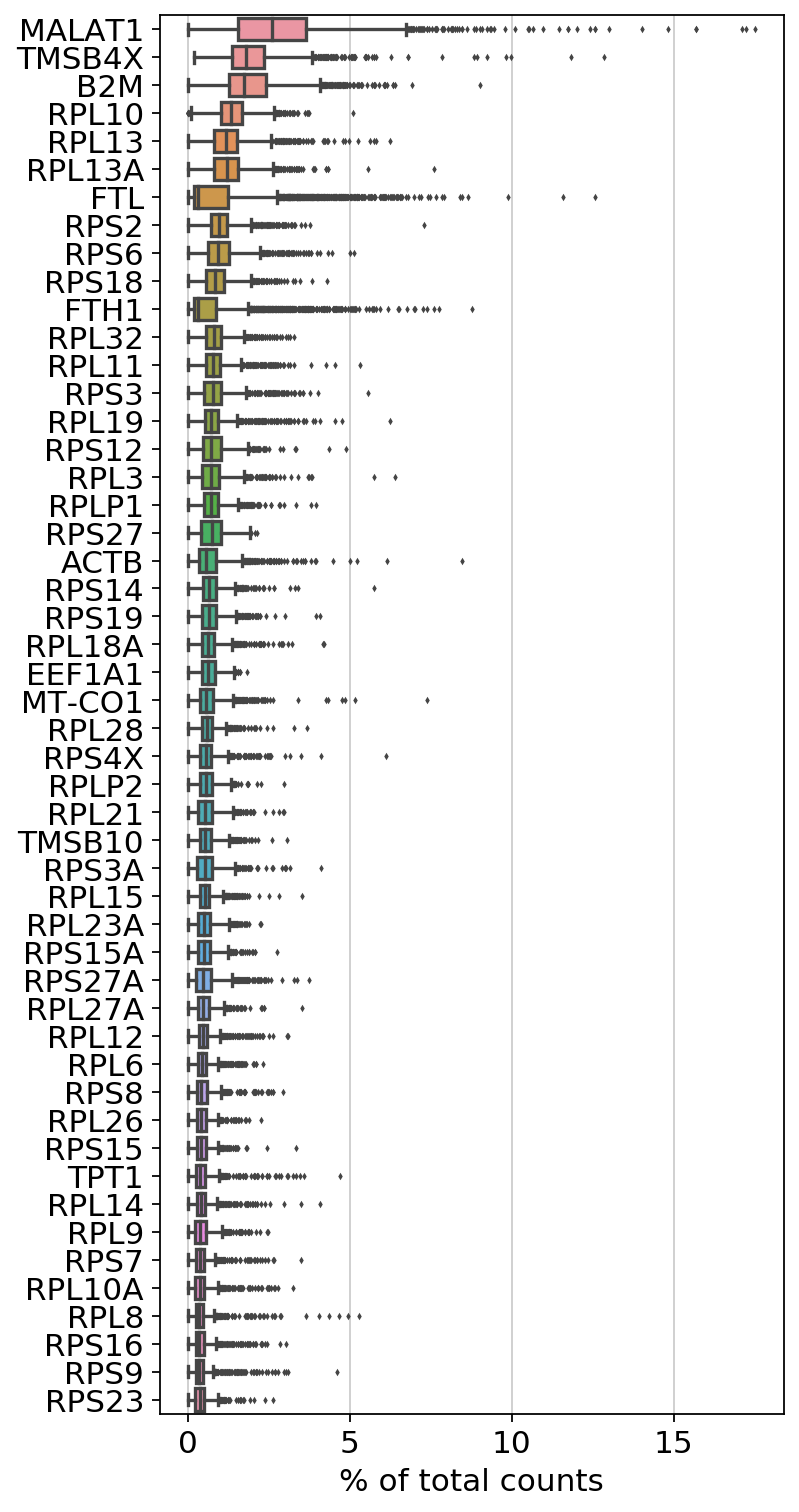

In [11]:
sc.pl.highest_expr_genes(adata, n_top=50)

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [26]:
mito_genes = adata.var_names.str.startswith('MT-') # the output is a boolean
mito_genes

array([False, False, False, ..., False, False, False])

In [28]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [31]:
adata.obs.head(10)

,n_genes,percent_mito,n_counts
0,,,
AAACATACAACCAC-1,781,0.030178,2419.0
AAACATTGAGCTAC-1,1352,0.037936,4903.0
AAACATTGATCAGC-1,1131,0.008897,3147.0
AAACCGTGCTTCCG-1,960,0.017431,2639.0
AAACCGTGTATGCG-1,522,0.012245,980.0
AAACGCACTGGTAC-1,782,0.016644,2163.0
AAACGCTGACCAGT-1,783,0.038161,2175.0
AAACGCTGGTTCTT-1,790,0.030973,2260.0
AAACGCTGTAGCCA-1,533,0.011765,1275.0


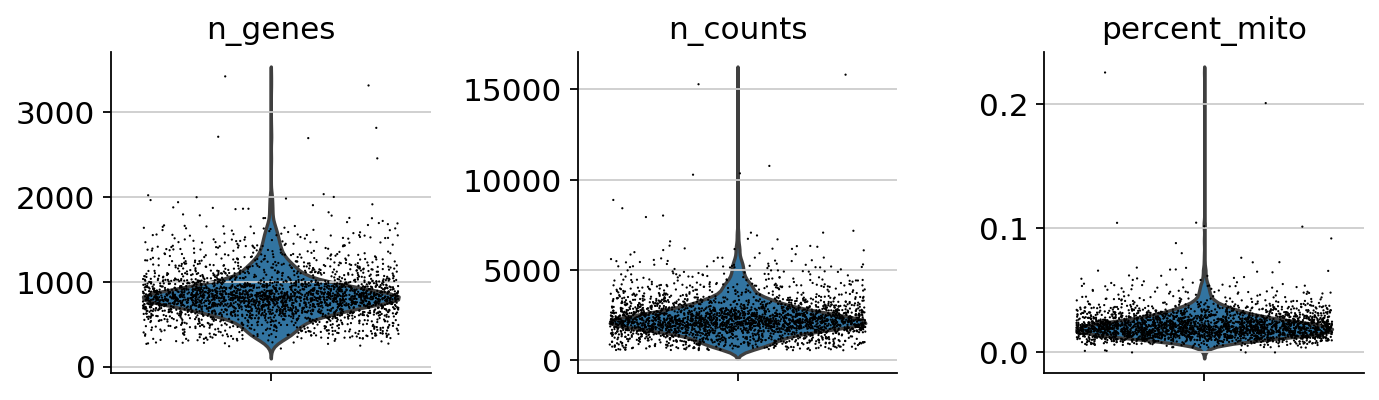

In [32]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


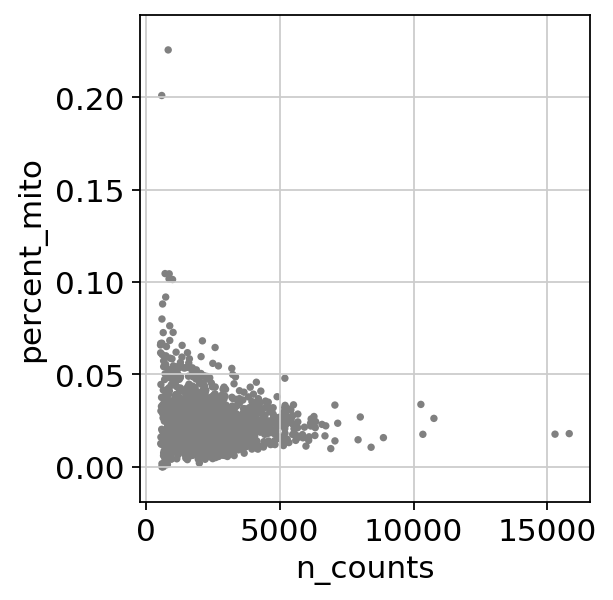

/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


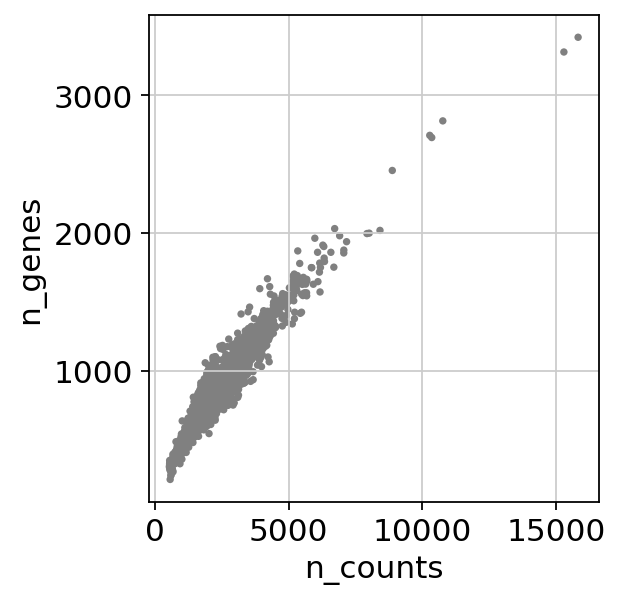

In [33]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts.

sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [34]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

## perform filtering

In [35]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]


In [36]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

### Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

1. manually choose to scale the cells to 10,000 reads per cell.
2. if counts_per_cell_after=None: will equals to the median of counts per cells before scaling.

In [40]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [41]:
sc.pp.log1p(adata)

Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the “relevant data” for visualization and differential testing, some would prefer to store the unnormalized data.

In [42]:
adata.raw = adata


In [43]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [45]:
adata.var.head()

,gene_ids,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000237683,9,False,0.013556,1.432845,-0.624328
AP006222.2,ENSG00000228463,3,False,0.004696,1.458631,-0.573415
RP11-206L10.2,ENSG00000228327,5,False,0.005673,1.325459,-0.836359
RP11-206L10.9,ENSG00000237491,3,False,0.002644,0.859264,-1.756848
LINC00115,ENSG00000225880,18,False,0.027437,1.457477,-0.575692


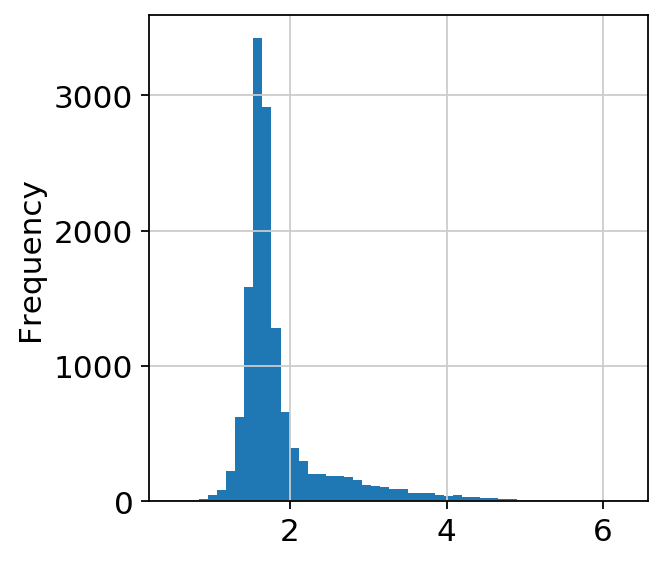

In [48]:
adata.var.dispersions.plot(kind = 'hist', bins = 50)

In [49]:
adata.var.highly_variable.sum()

1838

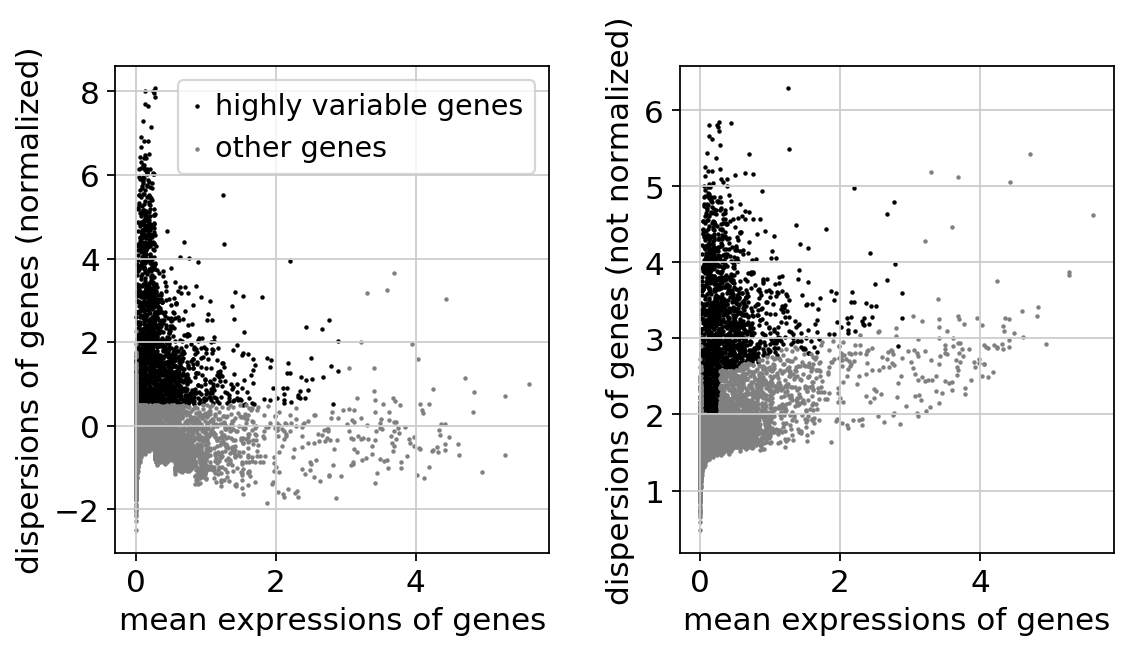

In [50]:
sc.pl.highly_variable_genes(adata)

### perform the filtering by taking only the highly variable genes

In [51]:
adata = adata[:, adata.var['highly_variable']]

In [52]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [53]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.17)


In [54]:
sc.pp.scale(adata, max_value=10)

In [62]:
adata.X

array([[-0.16400115, -0.28509128, -0.07065396, ..., -0.06058535,
        -0.19982634, -0.56654257],
       [-0.10205307, -0.2798674 , -0.04293836, ..., -0.08543857,
        -0.22721305, -0.5462736 ],
       [-0.34610933, -0.26972917, -0.05408725, ..., -0.10956272,
        -0.1475802 ,  1.3933632 ],
       ...,
       [-0.23622715, -0.27429375, -0.04906765, ..., -0.09870124,
        -0.18343353,  2.0294554 ],
       [-0.24819145, -0.27379674, -0.0496142 , ..., -0.09988387,
        -0.17952971, -0.5074973 ],
       [-0.35636508, -0.26150587, -0.02967004, ..., -0.14155307,
        -0.15140758, -0.44208845]], dtype=float32)

## PCA

In [63]:

sc.tl.pca(adata, svd_solver='arpack')

computing PCA on highly variable genes


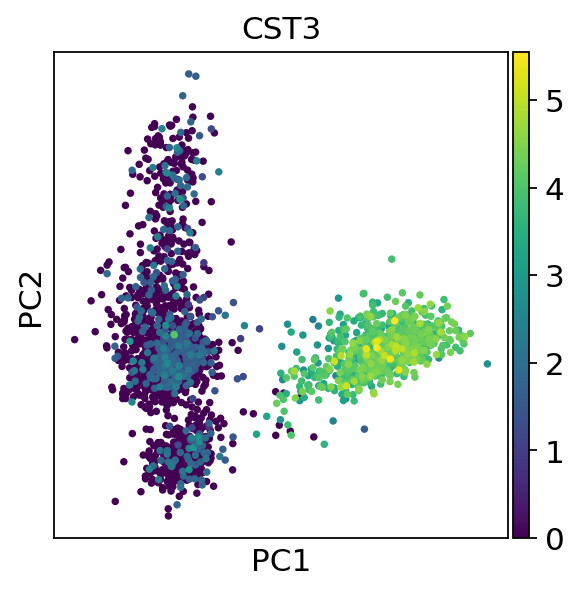

In [69]:
sc.pl.pca(adata, color='CST3', components = [1,2])

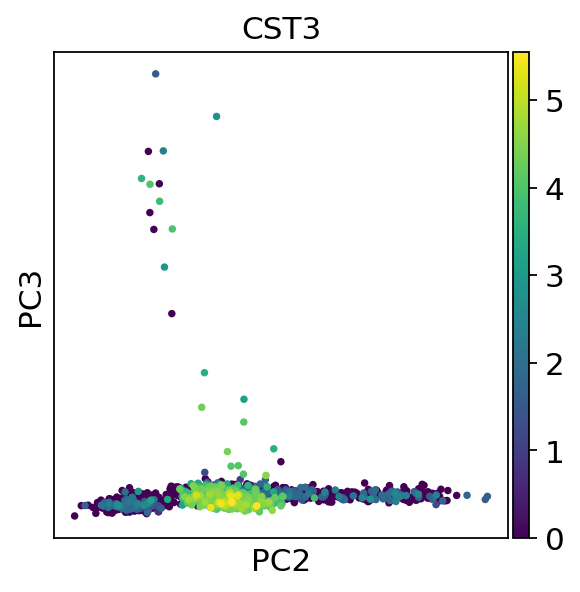

In [70]:
sc.pl.pca(adata, color='CST3', components = [2,3])

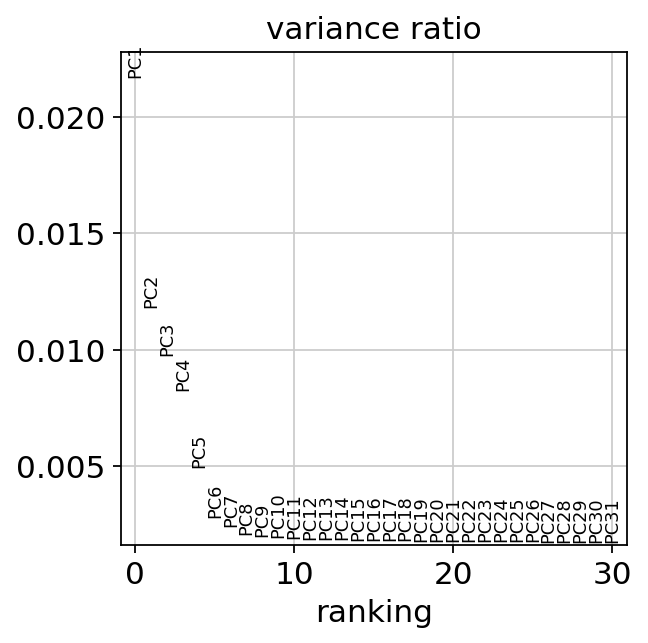

In [72]:

sc.pl.pca_variance_ratio(adata, log=False)

In [73]:
adata.write(results_file)

In [74]:
adata

# .obsm: X_pca has cells in the rows, and the components.

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [79]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:05.67) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [ ]:
# I'm not running this for now

tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

In [80]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:08.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)


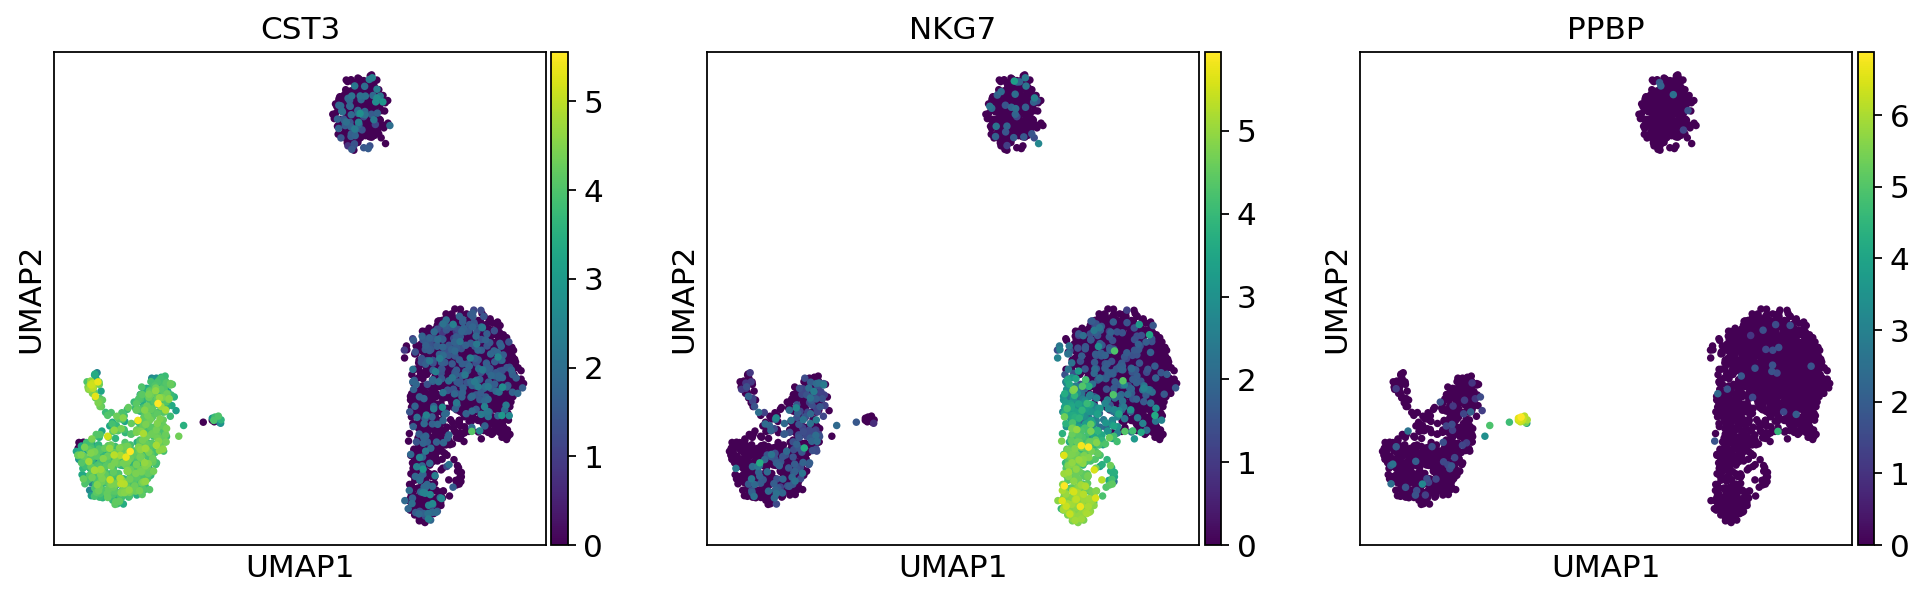

In [87]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

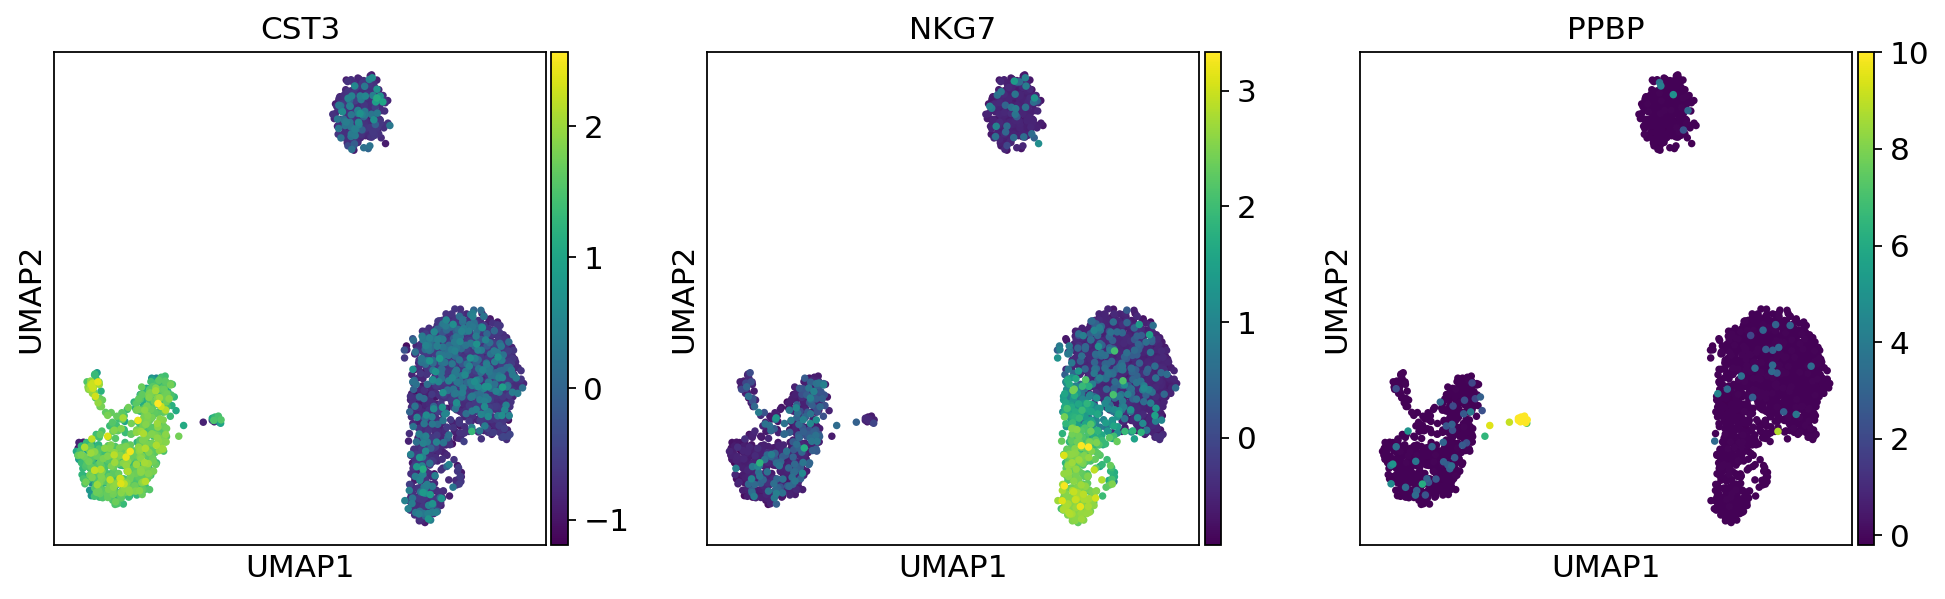

In [88]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [86]:
sc.pl.umap??

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [84]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.40) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


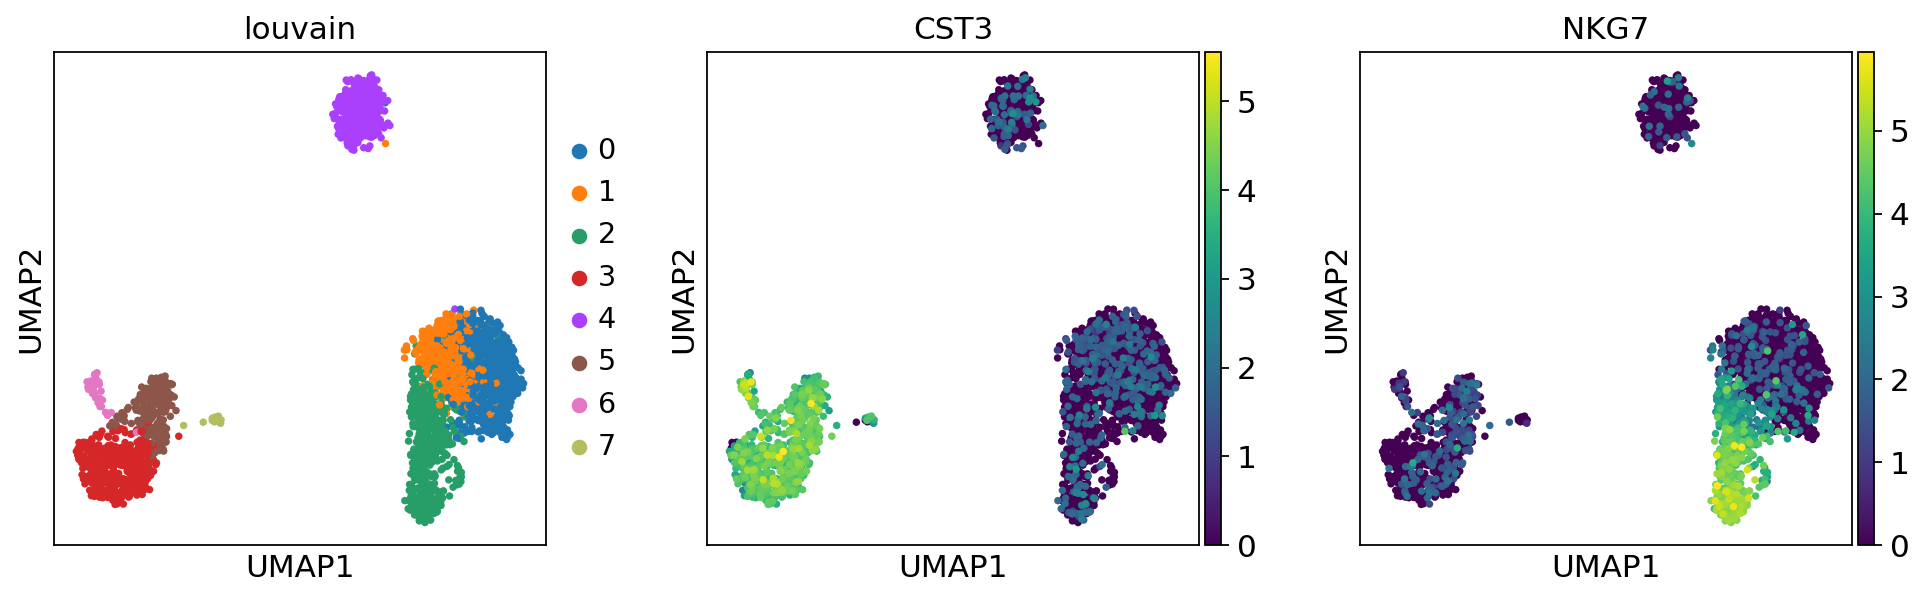

In [85]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

In [89]:

adata.write(results_file)

In [90]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

1. different method make very different list!
2. I don't think any of these method are very good.

ranking genes
    finished (0:00:00.83) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


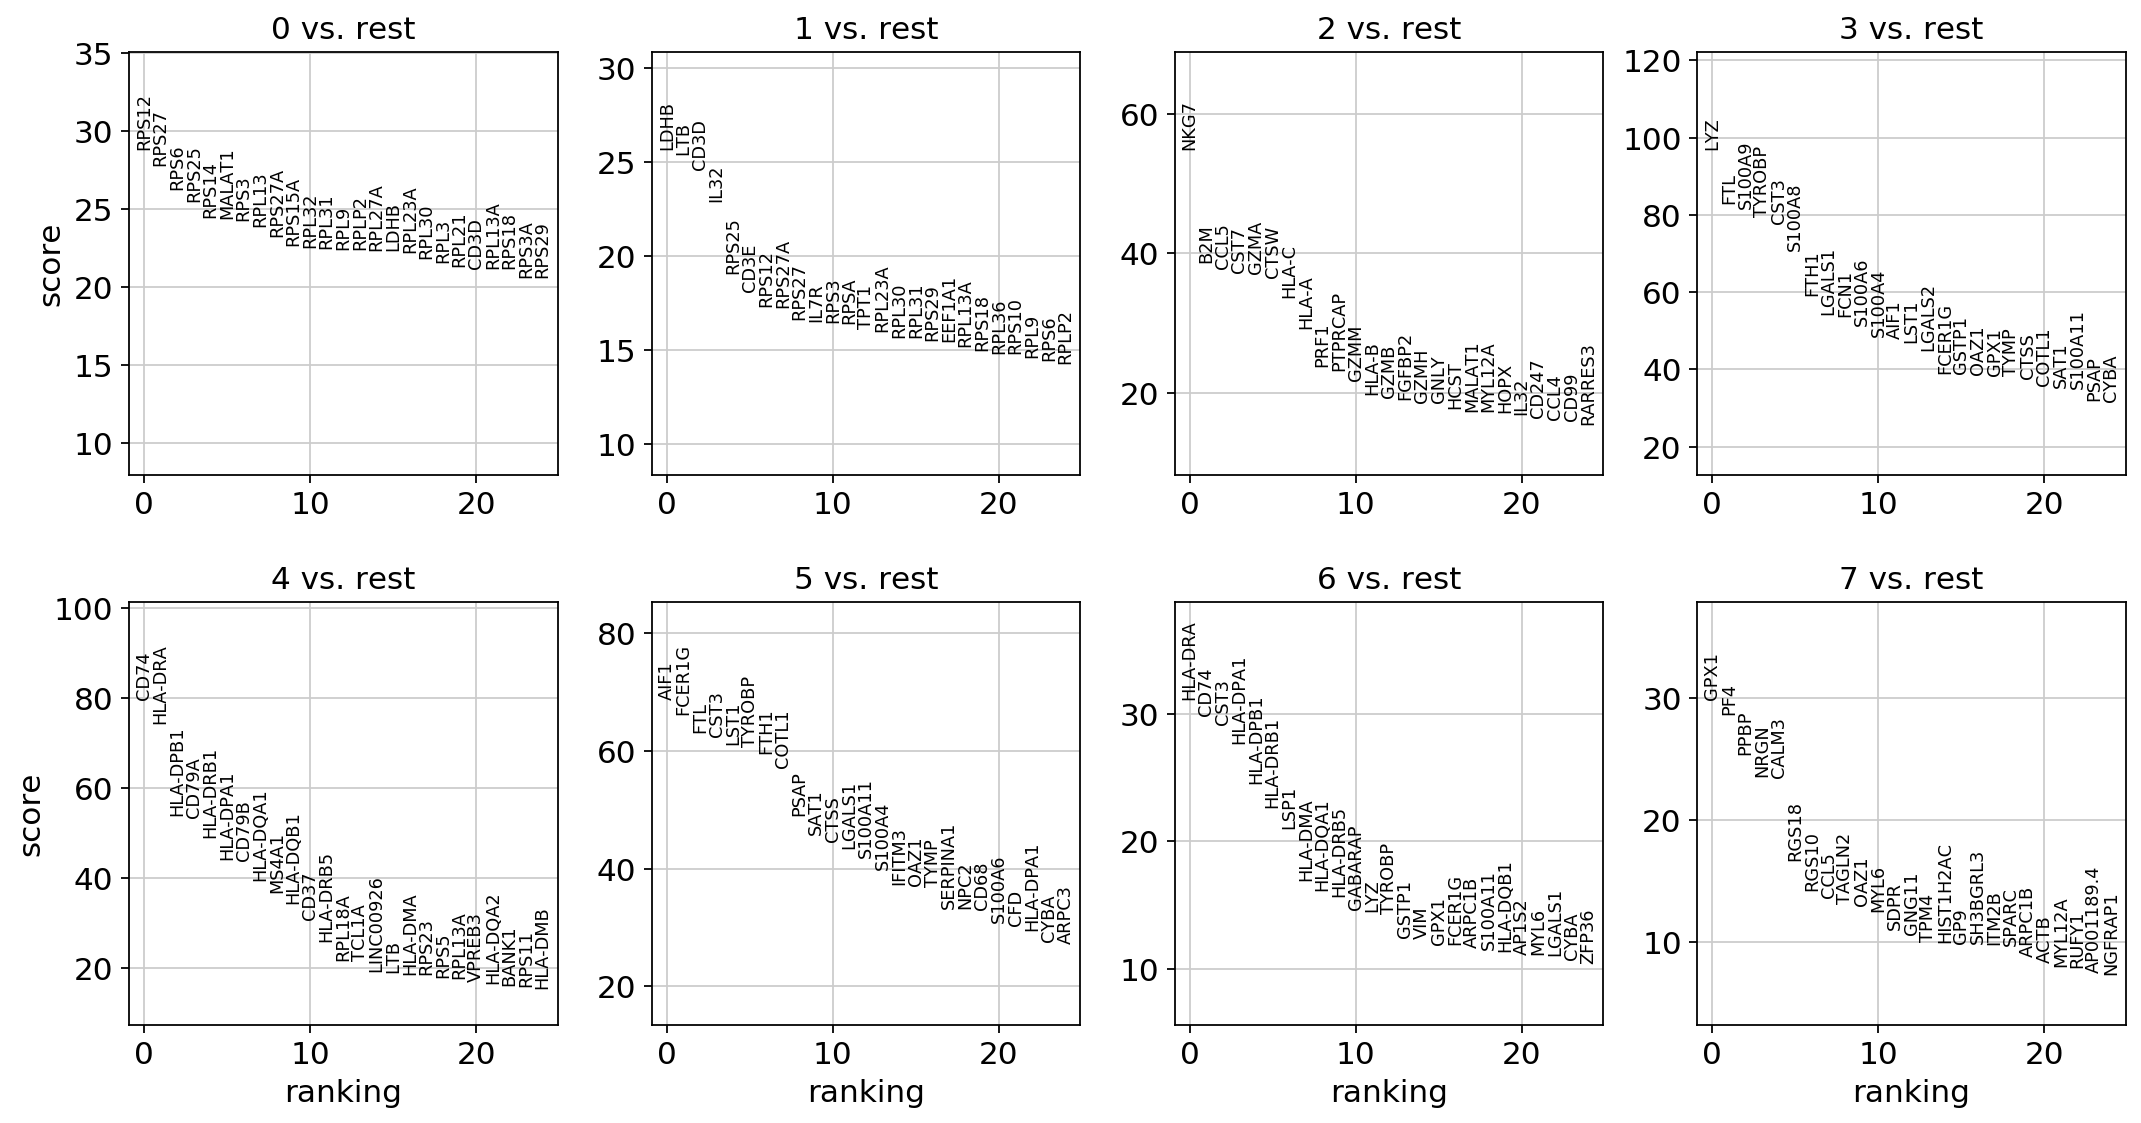

In [91]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [92]:
sc.tl.rank_genes_groups??

ranking genes


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:08.11) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids



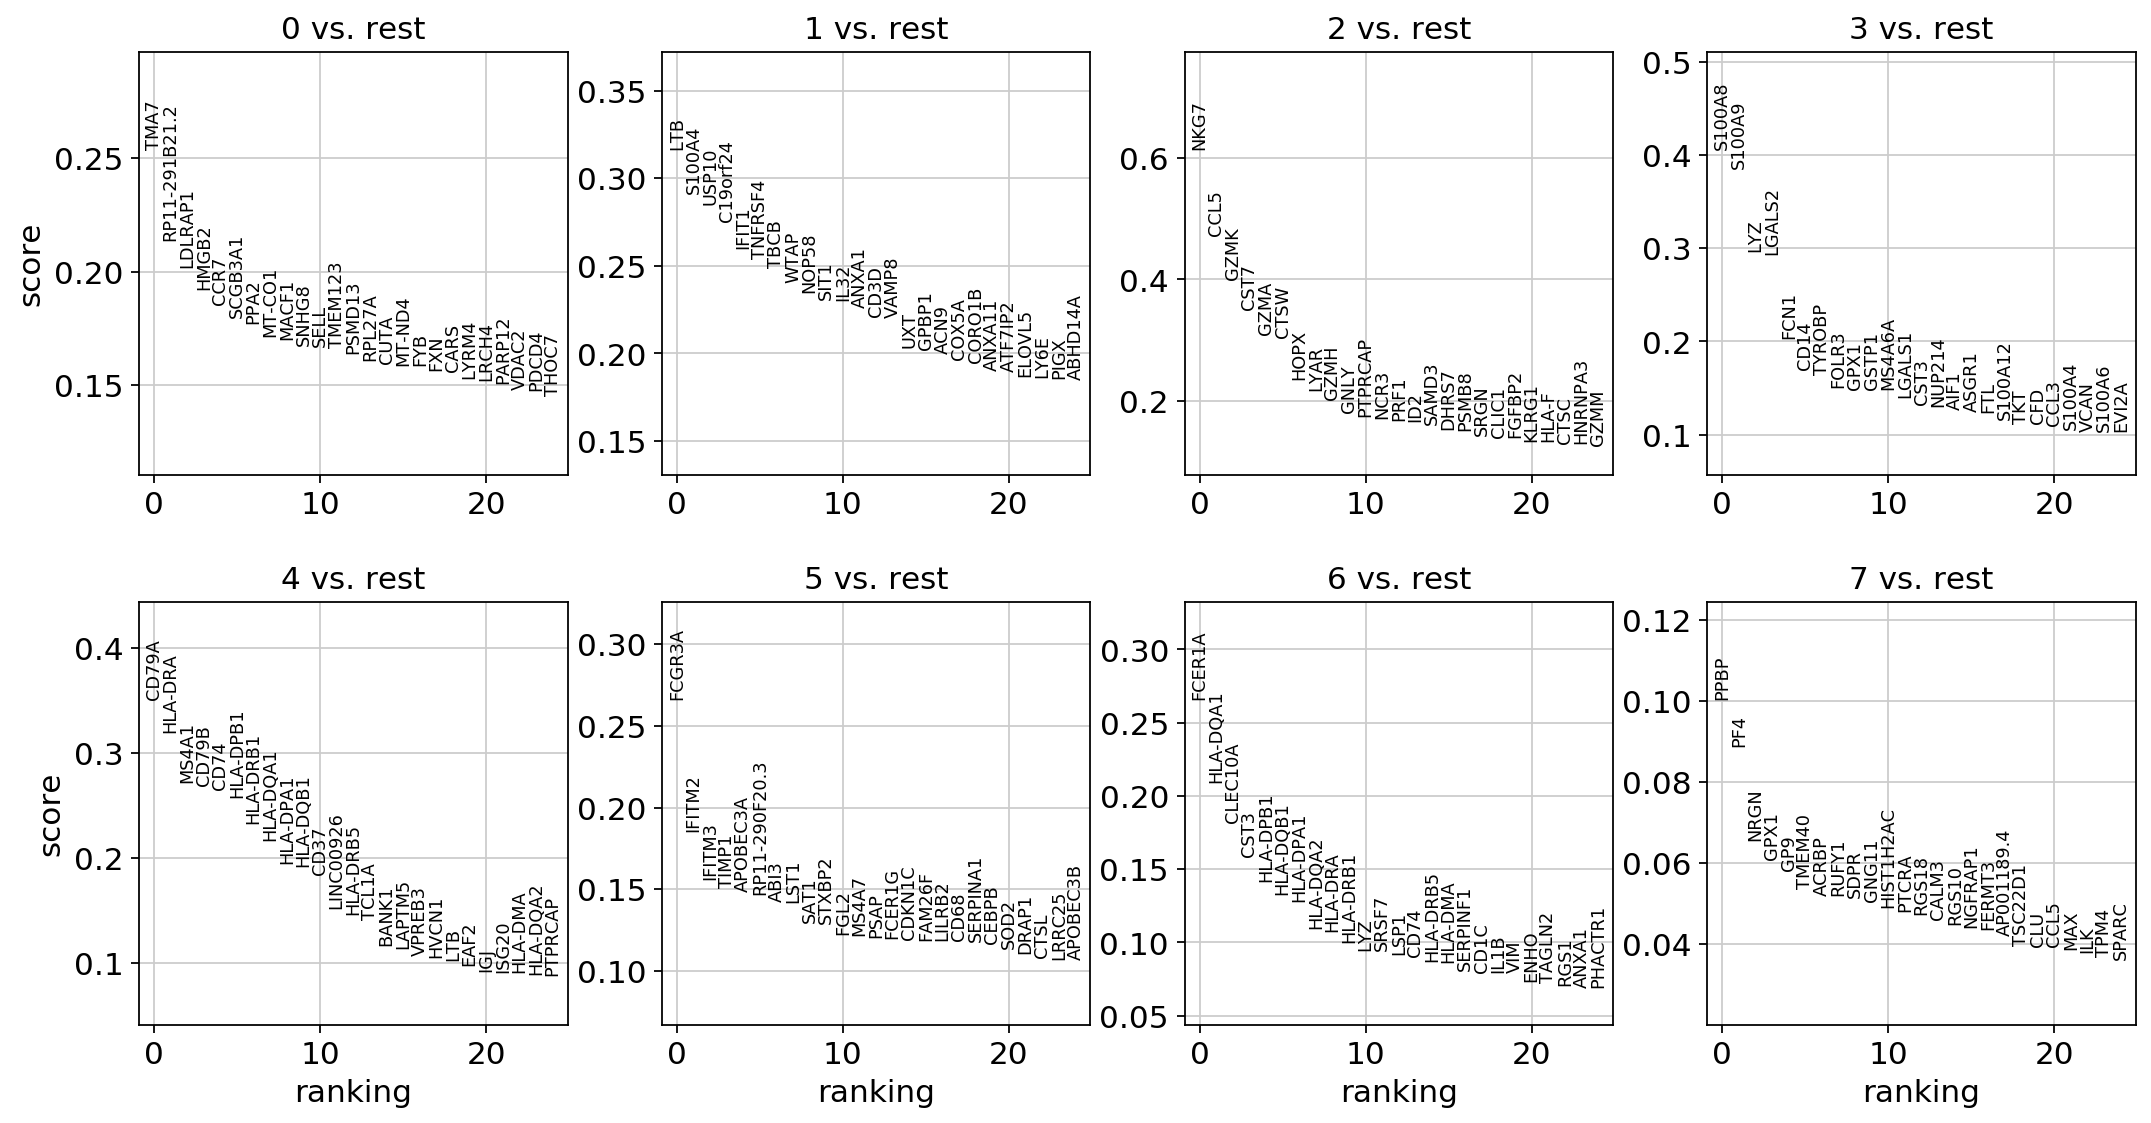

In [93]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:03.12) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


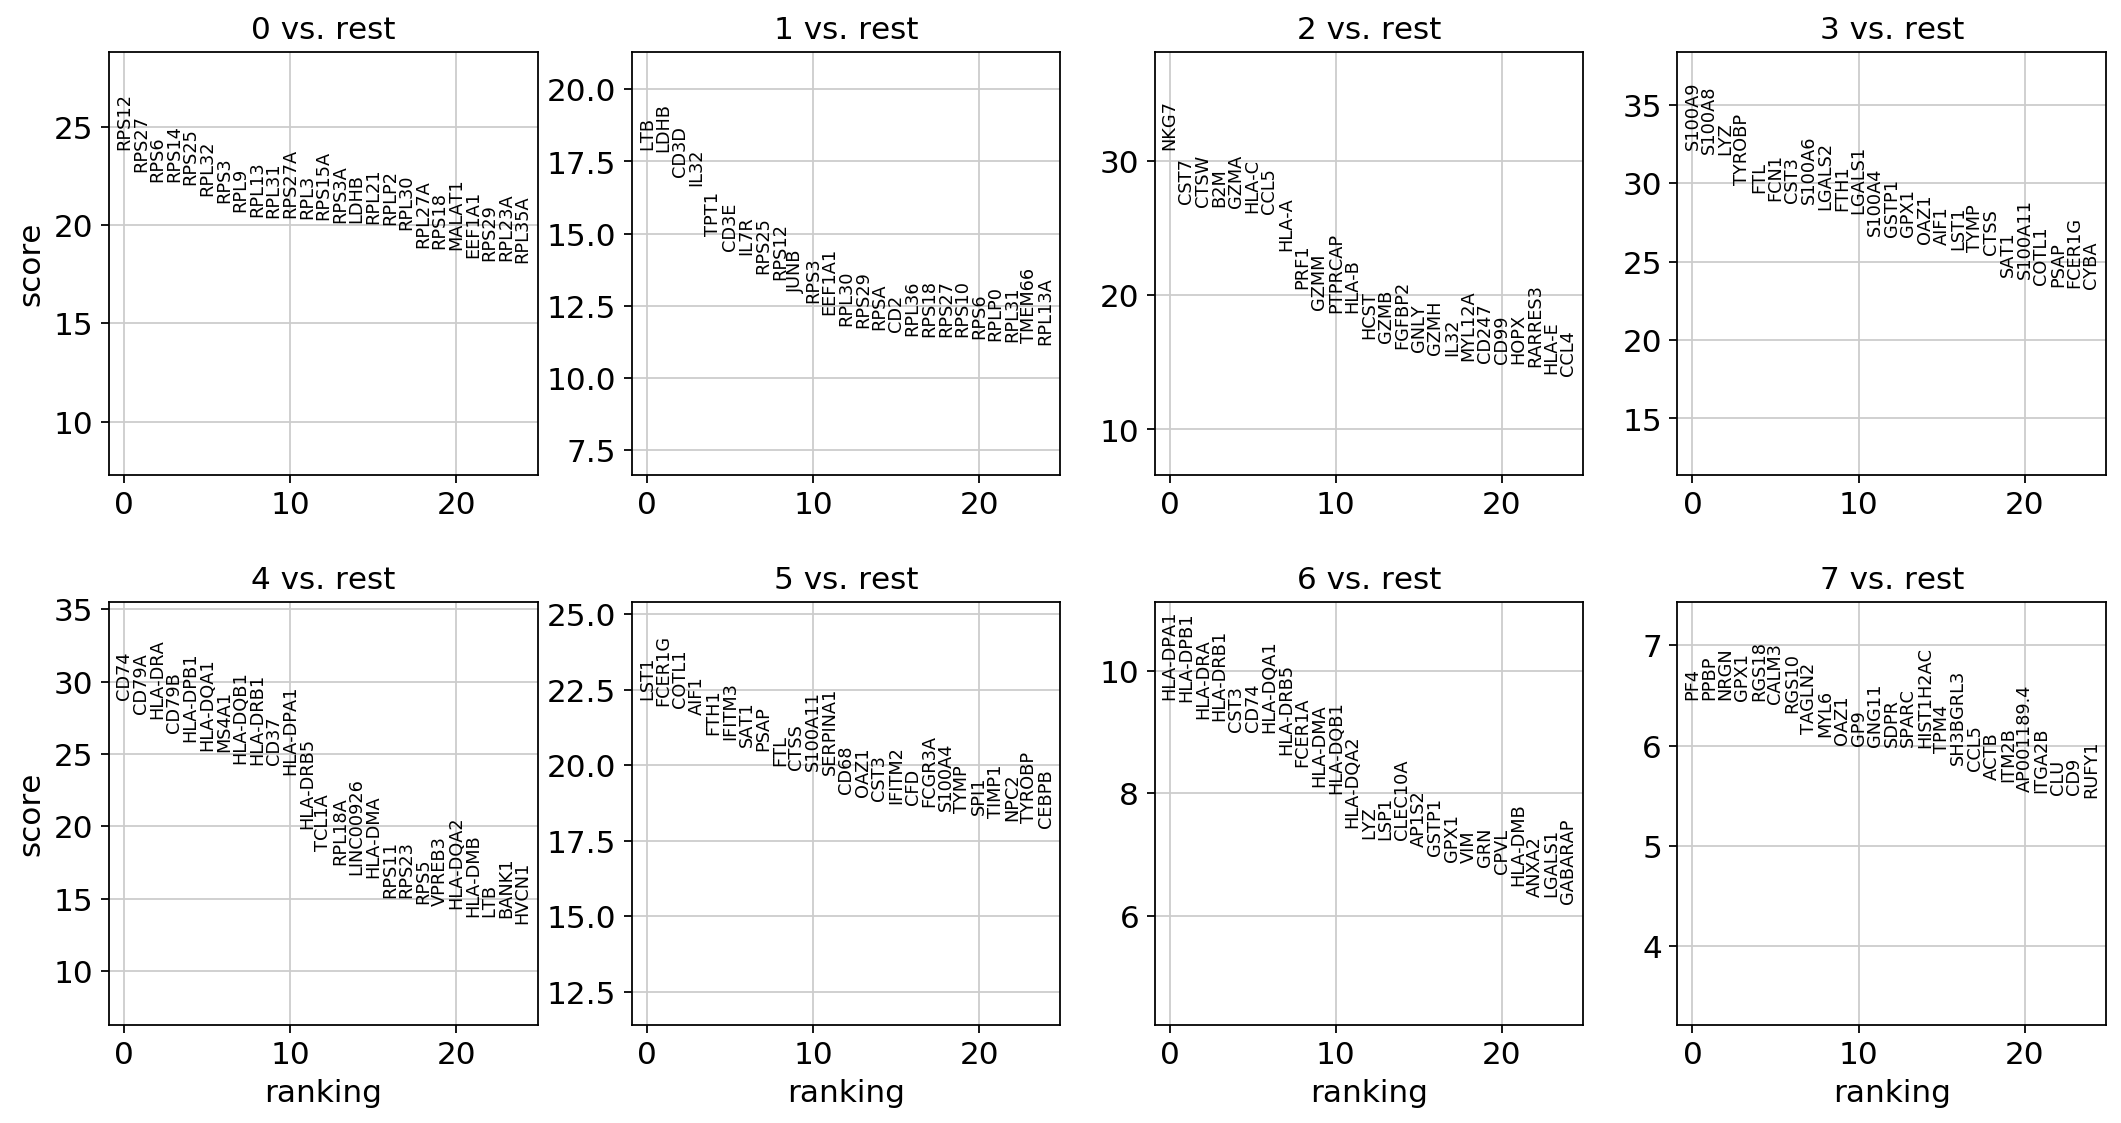

In [94]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [95]:

adata.write(results_file)



In [96]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [97]:
adata = sc.read(results_file)

/opt/conda/lib/python3.6/site-packages/anndata/readwrite/read.py:440: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,


In [98]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LTB,NKG7,S100A9,CD74,LST1,HLA-DPA1,PF4
1,RPS27,LDHB,CST7,S100A8,CD79A,FCER1G,HLA-DPB1,PPBP
2,RPS6,CD3D,CTSW,LYZ,HLA-DRA,COTL1,HLA-DRA,NRGN
3,RPS14,IL32,B2M,TYROBP,CD79B,AIF1,HLA-DRB1,GPX1
4,RPS25,TPT1,GZMA,FTL,HLA-DPB1,FTH1,CST3,RGS18


In [99]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,9.013969e-126,LTB,8.176730e-72,NKG7,6.187607e-209,S100A9,1.009749e-226,CD74,2.723938e-182,LST1,4.936821e-109,HLA-DPA1,1.529847e-21,PF4,1.031259e-10
1,RPS27,1.777691e-114,LDHB,3.111403e-71,CST7,1.102447e-158,S100A8,1.652941e-223,CD79A,2.536548e-170,FCER1G,5.433477e-107,HLA-DPB1,2.242690e-21,PPBP,1.033660e-10
2,RPS6,1.556704e-109,CD3D,1.258019e-64,CTSW,3.944902e-156,LYZ,3.700604e-222,HLA-DRA,7.824495e-166,COTL1,2.739069e-106,HLA-DRA,3.212898e-20,NRGN,1.040897e-10
3,RPS14,3.608309e-109,IL32,2.175824e-62,B2M,1.572937e-155,TYROBP,5.428042e-197,CD79B,2.327452e-154,AIF1,2.617073e-104,HLA-DRB1,4.290175e-20,GPX1,1.098044e-10
4,RPS25,8.213676e-108,TPT1,2.179112e-50,GZMA,2.087471e-155,FTL,2.981503e-190,HLA-DPB1,1.511333e-147,FTH1,5.820596e-98,CST3,2.030298e-19,RGS18,1.150221e-10


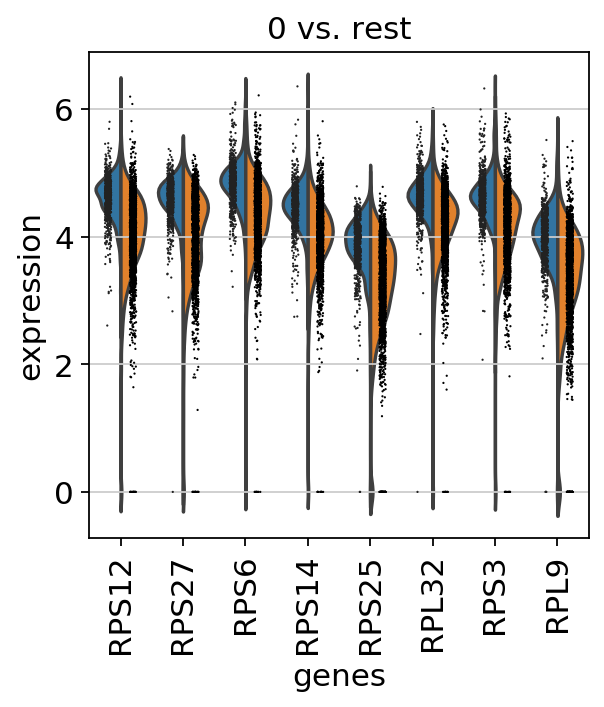

In [100]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

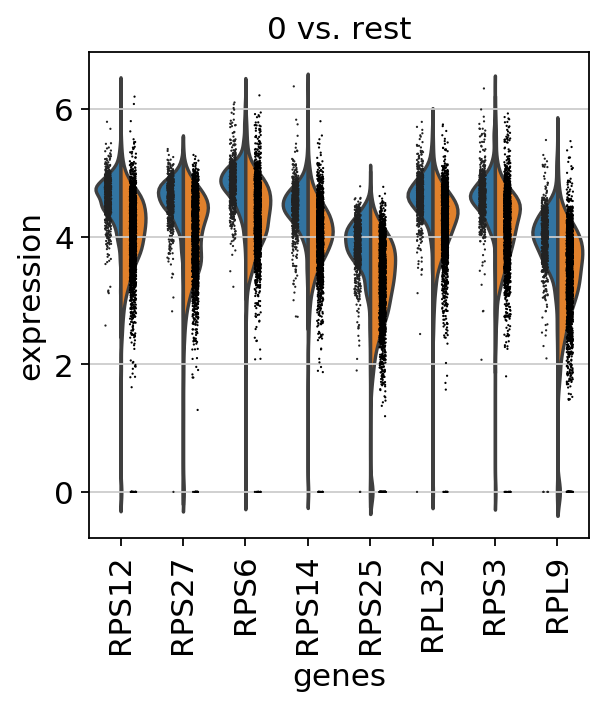

In [101]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

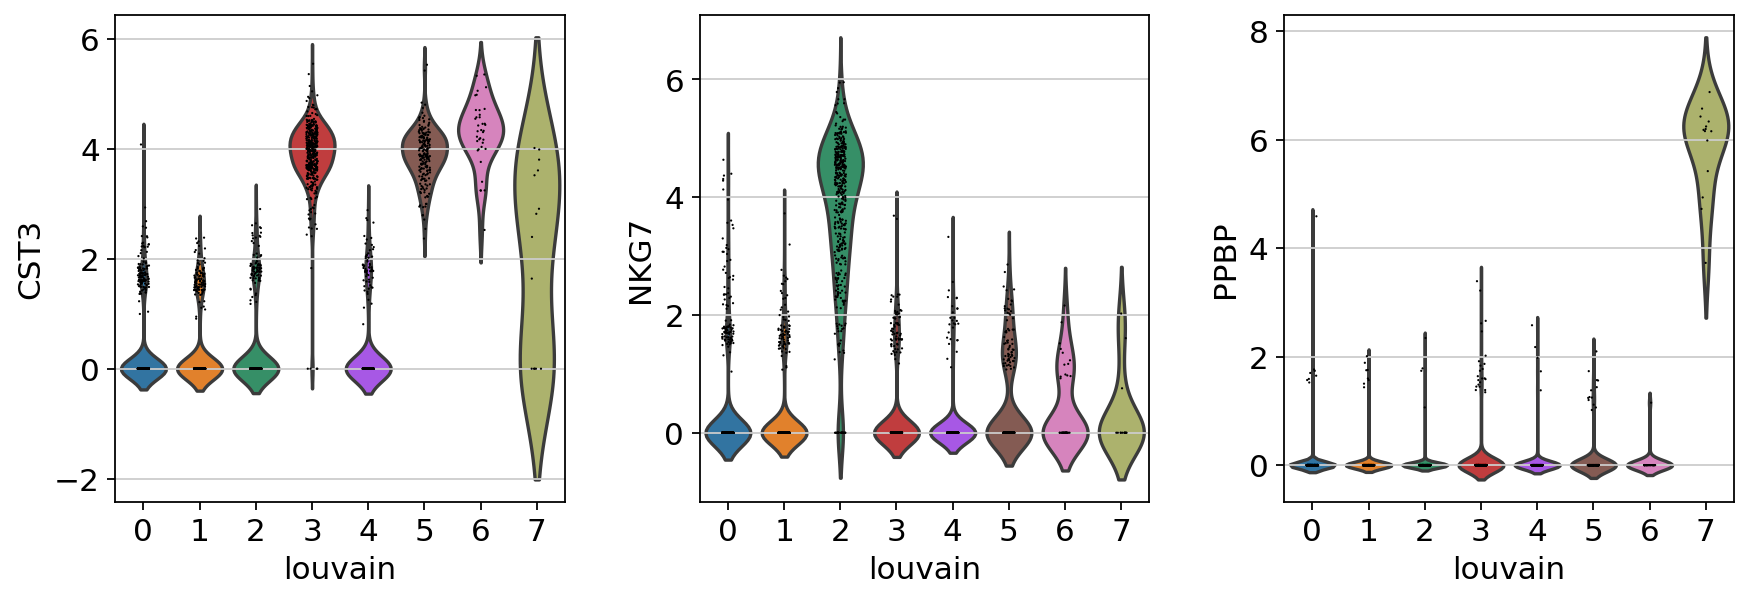

In [102]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [103]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

saving figure to file ./figures/umap.pdf


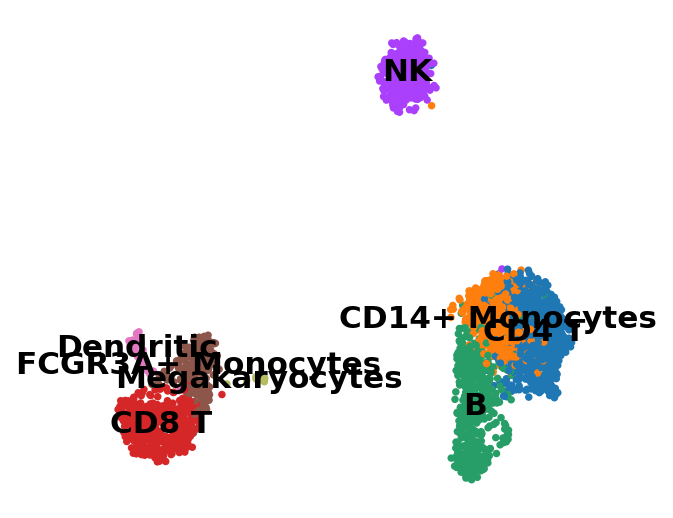

In [104]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')


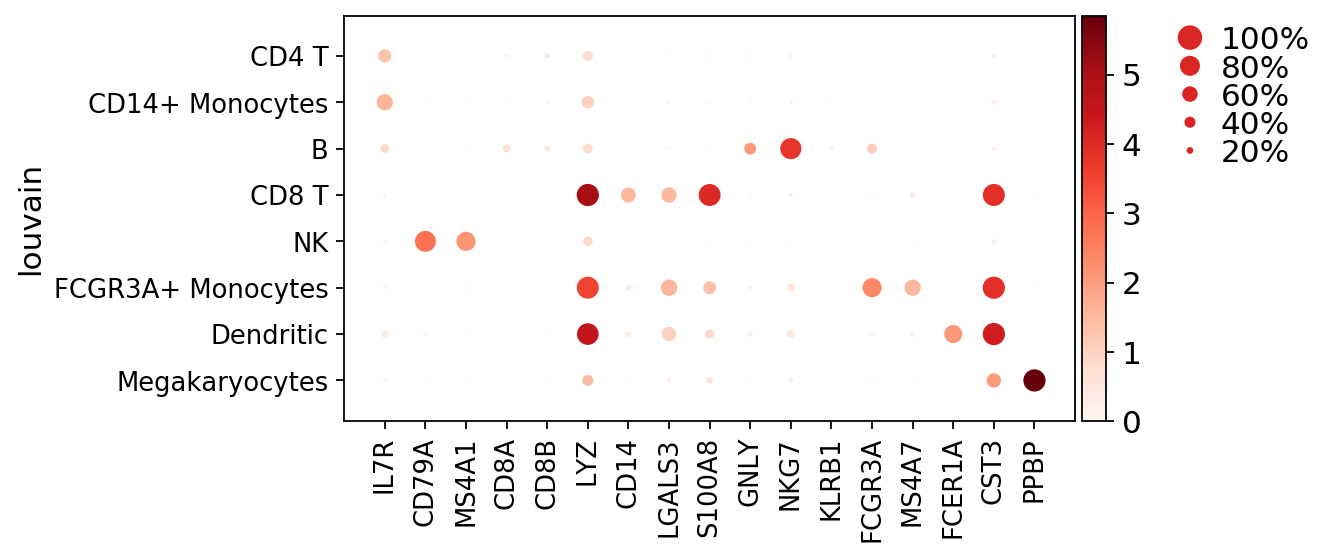

In [105]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

/opt/conda/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


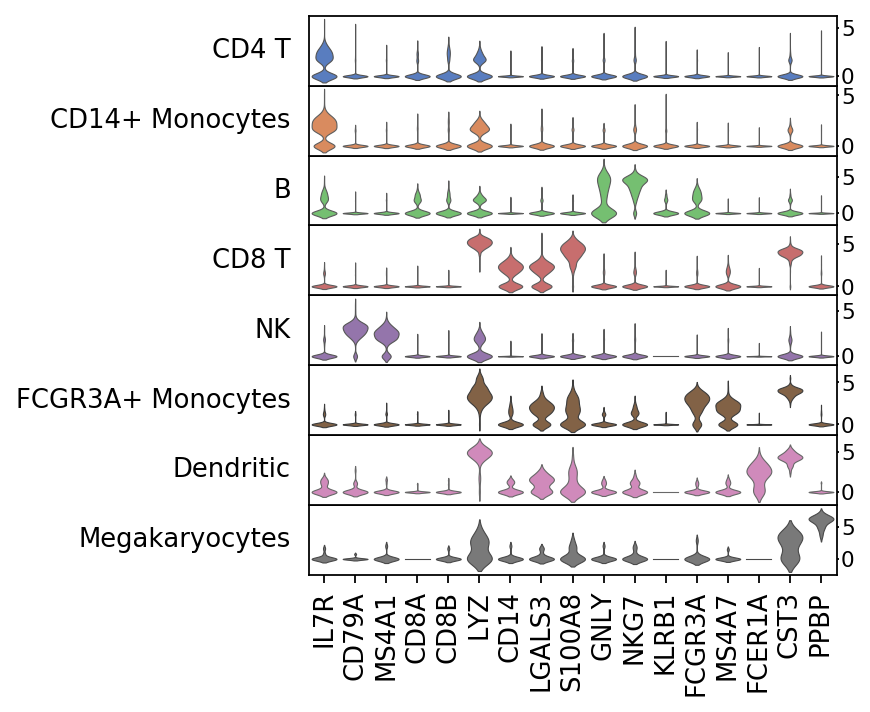

In [106]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [107]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [108]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading


If you want to export to “csv”, you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )